# Exploring venues in Chandigarh, India

## Table of Contents

* [Introduction](#introduction)
* [Data Collection from APIs](#data_collection)
* [Exploratory Data Analysis and Data Cleaning](#data_cleaning)
* [Methodolgy](#methodology)
* [Analysis and Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

The aim of the project is to identify venues in Chandigarh, India based on their rating and average prices. In this notebook, we will identify various venues in the city of **Chandigarh, India**, using **Foursquare API** and **Zomato API**, to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Here, we'll **identify places that are fit for various individuals** based on the information collected from the two APIs and Data Science.

## Data <a name="data"></a>

To begin with, we will take a look at **Chandigarh on the Map** using the `folium` library.

We will also fetch the data from two different APIs and then find a way to combine them together.
* **Foursquare API:** We will use the Foursquare API to fetch venues in Chandigarh starting from the middle upto 44Kilometers in each direction.
* **Zomato API:** The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

### Chandigarh

**Chandigarh** is composed of a number of sectors spread across a total area of 114 sq Km. There are many venues (especially restaurants, hotels and cafes) which can be explored.

We can use the `geopy` library to extract the latitude and longitude values of Chandigarh but it seems off and thus, we'll directly supply the values in this case.

In [35]:
CHD_LATITUDE = '30.7333'
CHD_LONGITUDE = '76.7794'
print('The geograpical coordinates of Chandigarh are {}, {}.'.format(CHD_LATITUDE, CHD_LONGITUDE))

The geograpical coordinates of Chandigarh are 30.7333, 76.7794.


Let's use the `folium` library to create a **complete map zoomed on Chandigarh**. We'll also plot a marker on the coordinates we just identified above. This would give us a relatively good look at the center point we will be considering. 

In [36]:
chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)
folium.Marker([CHD_LATITUDE, CHD_LONGITUDE]).add_to(chandigarh_map)
chandigarh_map.save("maps/Chandigarh Map.html")
chandigarh_map

### Foursquare API

We begin by fetching a total of all venues in **Chandigarh** upto a range of 4 Kilometers using the Foursquare API. The Foursquare API has the `explore` API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [81]:
FOURSQUARE_CLIENT_ID = '0HH2B0MRFB2FALD3CL3SQAGF5KPCVO53DS5OEOKOP4MWUCJO'
FOURSQUARE_CLIENT_SECRET = 'D5KMPZK1RAFC0RSUS3VCUOIAIIA2KVCOWHIP1RJX3D1L0UQS'
RADIUS = 4000 # 4 Km
NO_OF_VENUES = 100
VERSION = '20190612' # Current date

We define the `get_category_type` method to get the correct category for each venue.

In [82]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

* Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account. 
* We will set the radius as 4 Kilometers. 
* The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [103]:
import requests

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        CHD_LATITUDE, 
                                                                        CHD_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 4.0 Km
Total 20 venues fetched within a total radius of 4.0 Km

Total 120 venues fetched


### Zomato API

The Zomato API allows using its search API allows us to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the `name`, `lat`, and `lng` values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

* The query will be the name of the venue.
* The start defines from what offset we want to start, so we'll keep it at 0.
* The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
* We will supply the latitude and longitude values.
* We will set the sorting criteria as `real_distance` so each time we get the venue we're searching based on location coordinates.

In [104]:
headers = {'user-key': 'b3a1c26ed20422bfaae7ada558744e1f'}
venues_information = []

for index, row in venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5


KeyboardInterrupt: 

## Exploratory Data Analysis and Data Cleaning <a name="data_cleaning"></a>

The data from multiple resources might not always align. Thus, it is an important step to carefully combine the data while removing any discrepencies.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium

from pandas.io.json import json_normalize

from sklearn.cluster import KMeans
ZOMATO_API_KEY = 

Next, I'll define various constants I'll access throughout the notebook as well as save the authorization keys for both APIs inside constants for easy access.

As the information is in the form of json, let's convert and save it into a dataframe.

In [40]:
venues.head(5)

,name,categories,lat,lng
0,Chandigarh Club,Non-Profit,30.764313,76.797189
1,Pizza Hut,Pizza Place,30.705602,76.801413
2,KFC,Fast Food Restaurant,30.722045,76.761208
3,Sector 23,Shop & Service,30.737817,76.765525
4,Books and Brew,Café,30.747169,76.775944


I now have the name, category and location of these venues.

## Explore venues

I now have the name, category and location of 100 venues in Chandigarh. Let's plot and see where they are located.

In [41]:
chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(venues['name'], venues['lat'], venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(chandigarh_map)  

chandigarh_map.save("maps/Venues by Foursquare.html")
chandigarh_map

Next, I'll check the distribution of venues based on the categories provided by Foursquare.

<BarContainer object of 43 artists>

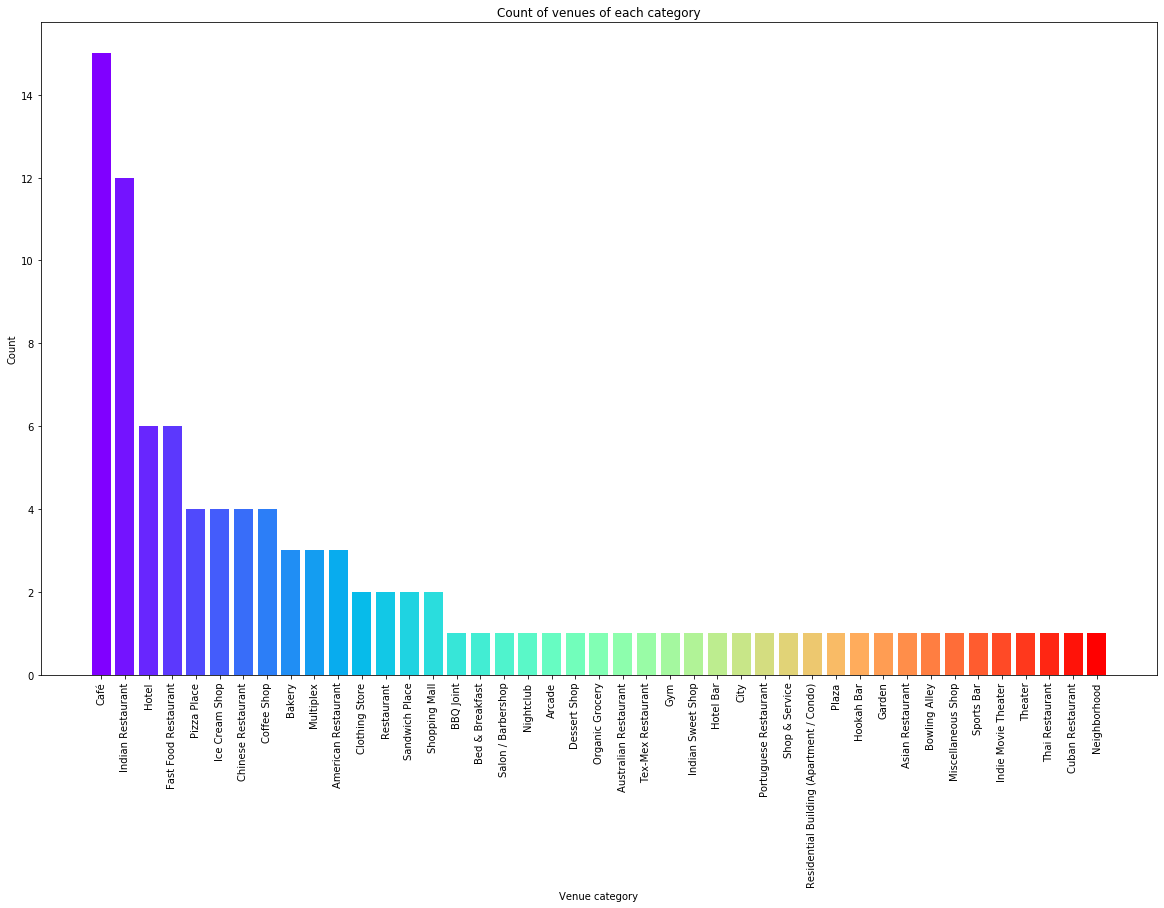

In [9]:
venue_distribution = venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category")
plt.ylabel("Count")
plt.title("Count of venues of each category")
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

In the complete list of venues, maximum venues are of type **Cafe** and **Indian Restaurant**.

## Get ratings and price for venues

I'll now use the Zomato API to fetch the rating as well as average cost for these locations.

In [11]:
print("Information fetched for {} places".format(venues_information.shape[0]))

Information fetched for 100 places


To combine the two datasets, I'll have to check that the latitude and longitude values of each corresponding venue match. Thus, I'll round both the latitude and longitude values upto 4 decimal places. Then, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [12]:
venues_information['latitude'] = venues_information['latitude'].apply(lambda lat: round(float(lat), 4))
venues_information['longitude'] = venues_information['longitude'].apply(lambda lng: round(float(lng), 4))
venues['lat'] = venues['lat'].apply(lambda lat: round(float(lat), 4))
venues['lng'] = venues['lng'].apply(lambda lng: round(float(lng), 4))

In [13]:
dataset = pd.concat([venues_information, venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [14]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,venue,latitude,longitude,price_for_two,price_range,rating,address,name,categories,lat,lng,lat_diff,lng_diff
0,Nik Baker's,30.7216,76.7601,700.0,2.0,4.5,"SCO 441 - 442, Sector 35 C, Sector 35, Chandigarh",Nik Bakers,Bakery,30.7214,76.7602,0.0002,-0.0001
1,Starbucks Coffee,30.7298,76.7732,500.0,2.0,3.6,"Hotel Aquamarine, Sector 22C, Near Sector 22, ...",The Coffee Bean & Tea Leaf,Coffee Shop,30.7297,76.7732,0.0001,0.0000
2,Peddlers,30.7208,76.7590,2200.0,4.0,3.9,"Hotel Heritage, SCO 467 & 468, Sector 35 C, Se...",Peddlers,American Restaurant,30.7208,76.7590,0.0000,0.0000
3,Barista,30.7222,76.7614,600.0,2.0,3.7,"SCO 422, Sector 35 C, Sector 35, Chandigarh",Barista,Café,30.7222,76.7615,0.0000,-0.0001
4,Sundarams,30.7302,76.7735,350.0,1.0,3.4,"Hotel Aroma Complex, Himalaya Marg, Sector 22 ...",Aroma 22,Hotel Bar,30.7301,76.7736,0.0001,-0.0001
5,OvenFresh,30.7217,76.7604,1600.0,3.0,4.6,"SCO 437 & 438, Sector 35 C, Sector 35, Chandigarh",Ovenfresh,American Restaurant,30.7218,76.7607,-0.0001,-0.0003
6,United Taste of Burgers,30.7342,76.7534,250.0,1.0,0,"Booth 158, Sector 36, Chandigarh",Sector 36,Plaza,30.7343,76.7534,-0.0001,0.0000
7,Classic 44,30.7149,76.7518,200.0,1.0,3.4,"SCO 413, Sector 44 D, Sector 44, Chandigarh",Classic 44,Bakery,30.7147,76.7518,0.0002,0.0000
8,FROYO - Frozen Yogurt & Treats,30.7235,76.7675,300.0,1.0,3.4,"2nd Floor, Piccadily Cinema, Sector 34, Chandi...",Piccadily Square,Multiplex,30.7235,76.7675,0.0000,0.0000
9,Pizza Hut,30.7058,76.8012,900.0,2.0,3.6,"320, 3rd Floor, Elante Mall, Phase 1, Chandiga...",Elante Mall,Shopping Mall,30.7056,76.8012,0.0002,0.0000


Taking a look at the names of venues from both APIs, some names are a complete mismatch.

**Category 1:** There are venues that have specific restaurants/cafes inside them as provided by Zomato API (Pizza Hut in Elante Mall).

**Category 2:** Two locations are so close by that they have practically same latitude and longitude values (The PIzza Kitchen and Zara).

**Category 3:** Some have been replaced with new restaurants (Uderdoggs has now been replaced by The Brew Estate).

The venues which belong to category 1 and category 3 are alright to keep, the venues that fall in category 2 should be removed.

In [15]:
selected_venues = selected_venues.drop([1, 10, 12, 17, 19, 24, 38, 44, 46, 48, 50, 51]).reset_index(drop = True)

I'll now select the venue name from **Zomato API**. I'll also get the average price per person by dividing the column `price_for_two` by 2 and removing this column from the dataset along with other unnecessary columns.

In [16]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'categories', 'lat_diff', 'lng_diff', 'price_for_two'])

Let's take a look at the final dataset that is left with us.

In [17]:
selected_venues.head(5)

,venue,latitude,longitude,price_range,rating,address,average_price
0,Nik Baker's,30.7216,76.7601,2.0,4.5,"SCO 441 - 442, Sector 35 C, Sector 35, Chandigarh",350.0
1,Peddlers,30.7208,76.7590,4.0,3.9,"Hotel Heritage, SCO 467 & 468, Sector 35 C, Se...",1100.0
2,Barista,30.7222,76.7614,2.0,3.7,"SCO 422, Sector 35 C, Sector 35, Chandigarh",300.0
3,Sundarams,30.7302,76.7735,1.0,3.4,"Hotel Aroma Complex, Himalaya Marg, Sector 22 ...",175.0
4,OvenFresh,30.7217,76.7604,3.0,4.6,"SCO 437 & 438, Sector 35 C, Sector 35, Chandigarh",800.0


I'll drop the venues which have `0.0` rating as it means it's not been rated yet.

In [18]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 41


## Rating and price analysis

Now, I'll explore the venues based on their rating and price values.

### Rating

Let's explore the rating first.

In [19]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()

Text(0.5, 1.0, 'Count of venues with given rating')

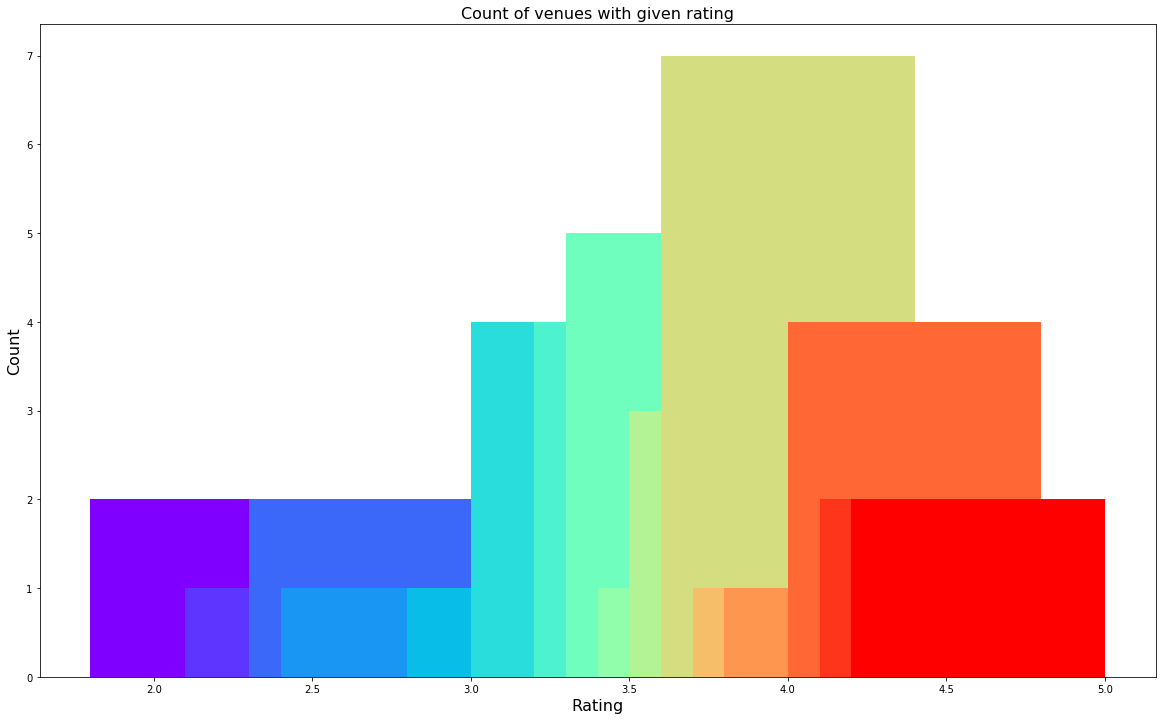

In [20]:
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that majority of the venues have their rating close to 4. Let's create bins for various ratings and plot them in different colors on the map.

In [21]:
bins = [0, 1, 2, 3, 4, 5]
labels = ['Bad', 'Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'], bins = bins, labels = labels, include_lowest = True)
selected_venues['rating_bin'] = selected_venues['rating_bin']

In [22]:
color_map = {'Bad': 'red', 'Low': 'lightred', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(chandigarh_map)  

chandigarh_map.save("maps/Venues Ratings.html")
chandigarh_map

The map has the location of all the venues. It appears that many venues are located near about **Sector 35**, **Sector 17** and **Elante Mall** with rating above 3. If someone wants to explore new venues, they should definitely check out Sector 35, Sector 17 or Elante Mall.

### Price

Let's take a look at the prices for various restaurants.

Text(0.5, 1.0, 'Count of venues with given average price')

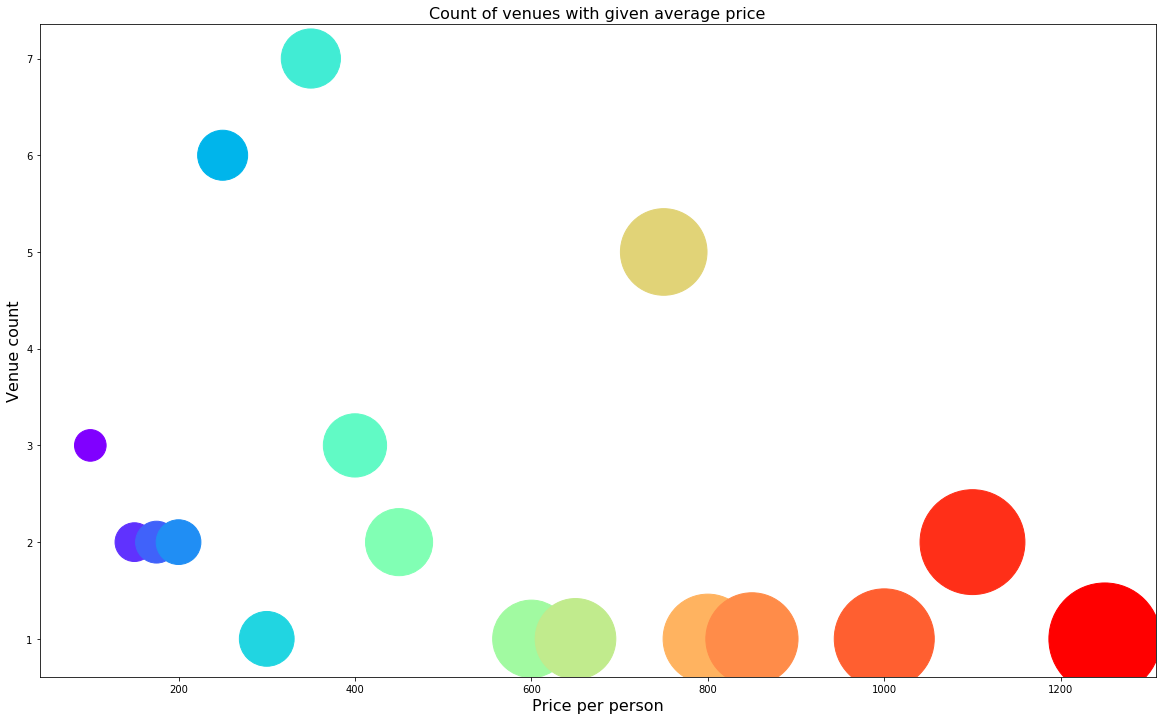

In [23]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

In the dataset, a large number of venues have an average price between Rs 200 and Rs 400.

Users might also be interested in going to a place that is not only rated high but also fit in their budget. I'll use the `price_range` column to plot the venues on a map.

In [24]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(chandigarh_map)  

chandigarh_map.save("maps/Venues Prices.html")
chandigarh_map

1. The venues near Sector 35 and Sector 17 are primarily lower priced.
2. The venues near Sector 7 and Sector 26 have steep prices.
3. Elante Mall seems to have a mix of both high priced and low priced venues.

## Clustering

I'll now cluster all these venues based on their price range, location and more.

In [25]:
clustering = selected_venues.drop(['venue', 'address', 'rating_bin'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Nik Baker's,30.7216,76.7601,2.0,4.5,"SCO 441 - 442, Sector 35 C, Sector 35, Chandigarh",350.0,Very good
1,1,Peddlers,30.7208,76.7590,4.0,3.9,"Hotel Heritage, SCO 467 & 468, Sector 35 C, Se...",1100.0,Good
2,0,Barista,30.7222,76.7614,2.0,3.7,"SCO 422, Sector 35 C, Sector 35, Chandigarh",300.0,Good
3,0,Sundarams,30.7302,76.7735,1.0,3.4,"Hotel Aroma Complex, Himalaya Marg, Sector 22 ...",175.0,Good
4,1,OvenFresh,30.7217,76.7604,3.0,4.6,"SCO 437 & 438, Sector 35 C, Sector 35, Chandigarh",800.0,Very good


In [26]:
chandigarh_map = folium.Map(location = [CHD_LATITUDE, CHD_LONGITUDE], zoom_start = 13)
color_map = { 0: 'red', 1: 'green'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(chandigarh_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(chandigarh_map)

chandigarh_map.save("maps/Venues Clusters.html")
chandigarh_map

From the map, we see the two clusters. 
1. The first cluster is spread across the whole city and includes the majority venues.
2. The second cluster is very sparsely spread and has very limited venues.

### Exploring venues in each cluster

I'll also check the venues of the two clusters.

In [27]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Nik Baker's,30.7216,76.7601,2.0,4.5,"SCO 441 - 442, Sector 35 C, Sector 35, Chandigarh",350.0,Very good
1,0,Barista,30.7222,76.7614,2.0,3.7,"SCO 422, Sector 35 C, Sector 35, Chandigarh",300.0,Good
2,0,Sundarams,30.7302,76.7735,1.0,3.4,"Hotel Aroma Complex, Himalaya Marg, Sector 22 ...",175.0,Good
3,0,Classic 44,30.7149,76.7518,1.0,3.4,"SCO 413, Sector 44 D, Sector 44, Chandigarh",100.0,Good
4,0,FROYO - Frozen Yogurt & Treats,30.7235,76.7675,1.0,3.4,"2nd Floor, Piccadily Cinema, Sector 34, Chandi...",150.0,Good
5,0,Pizza Hut,30.7058,76.8012,2.0,3.6,"320, 3rd Floor, Elante Mall, Phase 1, Chandiga...",450.0,Good
6,0,Old Pal Dhaba,30.7194,76.8017,2.0,3.4,"Booth 165-166, Sector 28 D, Sector 28, Chandigarh",400.0,Good
7,0,Softy Corner,30.7405,76.7816,1.0,4.6,"SCO 87, Sector 17, Chandigarh",150.0,Very good
8,0,Hot Millions,30.7408,76.7822,2.0,2.2,"SCO 73 & 74, Sector 17 D, Sector 17, Chandigarh",400.0,Okay
9,0,Cinnabon,30.7051,76.8018,2.0,4.4,"302 B&C, Next to PVR, Third Floor, Elante Mall...",250.0,Very good


In [28]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].mean()))

These venues for cluster 0 have mean price range of 1.68 and rating spread around 3.60


In [29]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Peddlers,30.7208,76.7590,4.0,3.9,"Hotel Heritage, SCO 467 & 468, Sector 35 C, Se...",1100.0,Good
1,1,OvenFresh,30.7217,76.7604,3.0,4.6,"SCO 437 & 438, Sector 35 C, Sector 35, Chandigarh",800.0,Very good
2,1,Mainland China,30.7256,76.8052,3.0,4.1,"SCO 40, Madhya Marg, Sector 26, Chandigarh",750.0,Very good
3,1,Cafe Nomad,30.7332,76.8032,3.0,3.9,"178, Inner Market, Sector 7, Chandigarh",750.0,Good
4,1,Virgin Courtyard,30.7348,76.7977,4.0,4.4,"SCO 1A, Backside, Madhya Marg, Sector 7C, Sect...",1100.0,Very good
5,1,The Brew Estate,30.7057,76.8006,4.0,4.4,"3rd Floor, #308, Elante Mall, Phase 1, Chandig...",1000.0,Very good
6,1,Cloud 9 - Hotel Shivalik View,30.7395,76.7767,3.0,3.7,"Hotel Shivalik View, Sector 17, Chandigarh",750.0,Good
7,1,Brooklyn Central,30.7052,76.8010,3.0,4.5,"51A, Courtyard, Ground Floor, Elante Mall, Pha...",650.0,Very good
8,1,Slounge - Lemon Tree Hotel,30.7055,76.8034,3.0,3.2,"Lemon Tree Hotel, Plot 3MW, Phase 1, Chandigar...",750.0,Good
9,1,The Billionaires Club,30.7096,76.8010,3.0,2.8,"4th Floor, City Emporium Mall, Phase 1, Chandi...",850.0,Okay


In [30]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].mean()))

These venues for cluster 1 have mean price range of 3.31 and rating spread around 3.97
